In [40]:
import pandas as pd
import numpy as np
import urllib.request 
import urllib.parse
import urllib.error
import ssl
import re
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as BS
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statistics import median
import statsmodels.formula.api as sm

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from dmba import plotDecisionTree, classificationSummary, regressionSummary

import matplotlib.pylab as plt
%matplotlib inline

In [92]:
df1 = pd.read_csv("Cleaned_data.csv")

In [93]:
df1.columns

Index(['List_price', 'Address', 'City', 'State', 'Beds', 'Baths',
       'Living_sqft', 'Property_Type', 'Year_Built', 'Est__Mo__Payment',
       'Price_Sq_Ft_', 'Drought_Score', 'Walk_score', 'Neighbourhood_Homes',
       'Transit_score', 'Groceries_stores', 'Services', 'Emergency',
       'Shopping', 'Food_and_Drink', 'Competitive_Score', 'has_supercenter',
       'has_major_indian_grocery', 'has_major_entertainment',
       'has_indian_restaurant', 'has_chinese_restaurant',
       'has_mexican_restaurant', 'has_boba', 'has_starbucks', 'property_url',
       'has_mall', 'Zipcode', 'No_of_Schools', 'Average_rating', 'County'],
      dtype='object')

In [94]:
len(df1.columns)

35

## Do the variables Living_sqft and other attributes affect the list price?

In [95]:
c = df1.corr()
correlation=c["List_price"].sort_values(ascending=False)
correlation=pd.DataFrame(correlation)
correlation

,List_price
List_price,1.000000
Est__Mo__Payment,0.999362
Living_sqft,0.715915
Price_Sq_Ft_,0.663444
Baths,0.532644
Beds,0.521508
Competitive_Score,0.242831
Average_rating,0.142057
has_major_entertainment,0.121357
Services,0.111544


In [96]:
df1 = df1.drop(columns = ['Est__Mo__Payment']) #dropping Est__Mo__Payment column because it is dependent on list_price
 

In [97]:
df1.loc[(df1.Walk_score >= 0) & (df1.Walk_score <= 49), 'Walk_score_cat'] = 'Car Dependent'
df1.loc[(df1.Walk_score >= 50) & (df1.Walk_score <= 69), 'Walk_score_cat'] = 'Somewhat Walkable'
df1.loc[(df1.Walk_score >= 70) & (df1.Walk_score <= 89), 'Walk_score_cat'] = 'Very Walkable'
df1.loc[(df1.Walk_score >= 90) & (df1.Walk_score <= 100), 'Walk_score_cat'] = 'Walkers Paradise'


In [98]:
df1 = df1.drop(columns = ["Walk_score"])

In [99]:
# 90–100	Walker's Paradise
# Daily errands do not require a car.
# 70–89	Very Walkable
# Most errands can be accomplished on foot.
# 50–69	Somewhat Walkable
# Some errands can be accomplished on foot.
# 25–49	Car-Dependent
# Most errands require a car.
# 0–24	Car-Dependent
# Almost all errands require a car


#https://www.redfin.com/how-walk-score-works ----- link for walk score catogories according to Redfin website

In [100]:
df1.loc[(df1.Transit_score >= 0) & (df1.Transit_score <= 24), 'Transit_score_cat'] = 'Minimal Transit'
df1.loc[(df1.Transit_score >= 25) & (df1.Transit_score <= 49), 'Transit_score_cat'] = 'Some Transit'
df1.loc[(df1.Transit_score >= 50) & (df1.Transit_score <= 69), 'Transit_score_cat'] = 'Good Transit'
df1.loc[(df1.Transit_score >= 70) & (df1.Transit_score <= 89), 'Transit_score_cat'] = 'Excellent Transit'
df1.loc[(df1.Transit_score >= 90) & (df1.Transit_score <= 100), 'Transit_score_cat'] = 'Riders Paradise'

In [101]:
df1.Transit_score_cat.value_counts()

Good Transit    2213
Name: Transit_score_cat, dtype: int64

In [102]:
## All the records have transit score catogory as "Good Transit", no influence on the list price. hence dropping this column
df1 = df1.drop(columns = ['Transit_score_cat', "Transit_score"])

In [103]:
df1.to_csv("Data_cleaned.csv", index = False)

In [104]:
# 90–100	Rider's Paradise
# World-class public transportation.
# 70–89	Excellent Transit
# Transit is convenient for most trips.
# 50–69	Good Transit
# Many nearby public transportation options.
# 25–49	Some Transit
# A few nearby public transportation options.
# 0–24	Minimal Transit
# It is possible to get on a bus.

<ipython-input-105-02f15535137f>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plots[0,].set_xticklabels(correlation.index, rotation=90,fontsize='small')


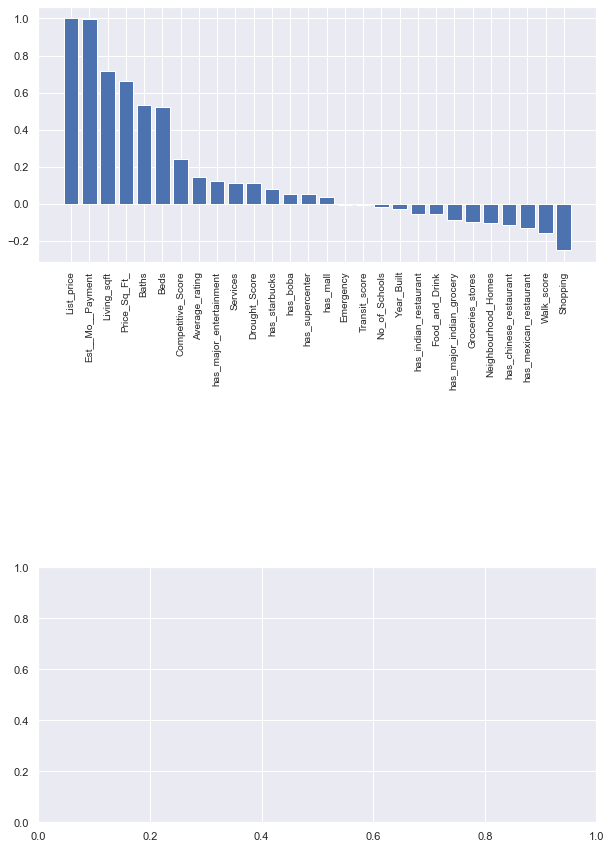

In [105]:
#Using matplotlib plt.subplots
fig, plots = plt.subplots(2,1)
plots[0].bar(correlation.index, correlation['List_price'],align='center')

plots[0,].set_xticklabels(correlation.index, rotation=90,fontsize='small')
plt.subplots_adjust(hspace = 1.2)
fig.set_figwidth(10)
fig.set_figheight(15)
plt.show()

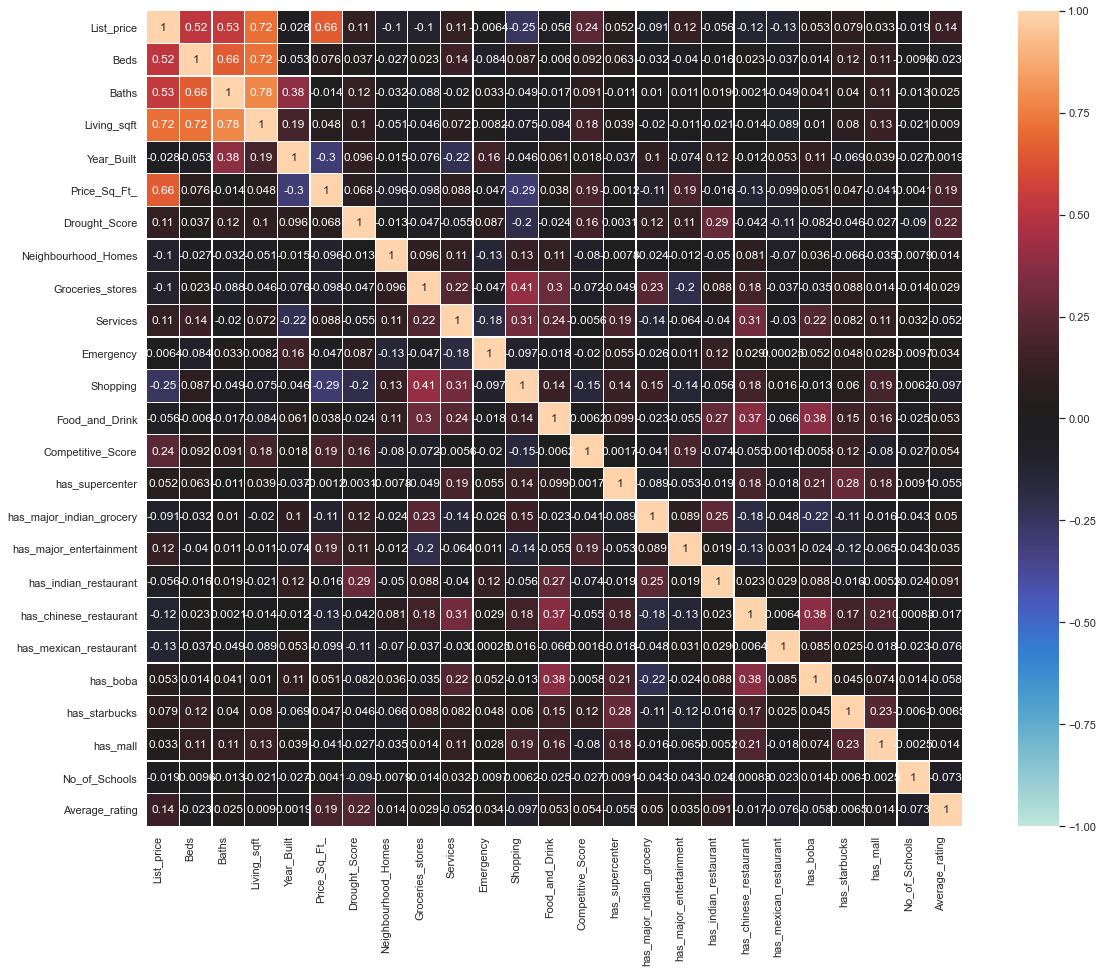

In [30]:
data = df1.drop(columns=['Address', 'City', 'State', 'Zipcode', 'County', 'Property_Type'])

corr = data.corr()
sns.set(rc = {'figure.figsize':(20,15)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(2, 500, n=200),
    square=True,
    annot = True,linewidths=.2
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [106]:
# Removing those variables which are correlated to each other
#Shopping is correlated with Grocery stores
#has_Boba with Food& drink
#has boba with has chinese restaurant

In [107]:
#dropping groceries_stores, Food&drink, shopping
df1.drop(columns=['Groceries_stores', 'Shopping', 'Food_and_Drink', 'Services'], inplace = True)

In [108]:
len(df1.columns)

29

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


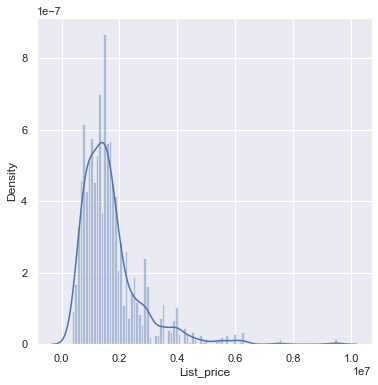

In [37]:
sns.distplot(df1['List_price'], color='b', bins=100, hist_kws={'alpha': 0.4})
sns.set(rc = {'figure.figsize':(6,6)})

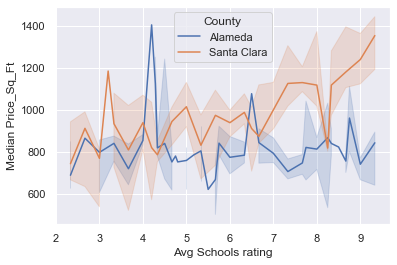

In [41]:
sns.lineplot(x = "Average_rating", y = 'Price_Sq_Ft_', data=df1, estimator = median, hue = 'County')
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
plt.xlabel('Avg Schools rating')
plt.ylabel('Median Price_Sq_Ft')
plt.show()

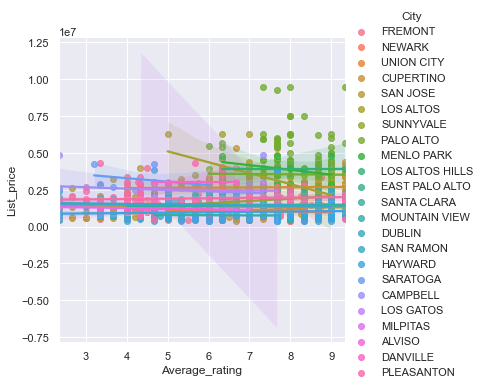

In [42]:
sns.lmplot(x = "Average_rating", y = 'List_price', data=df1, hue = "City")
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
plt.show()

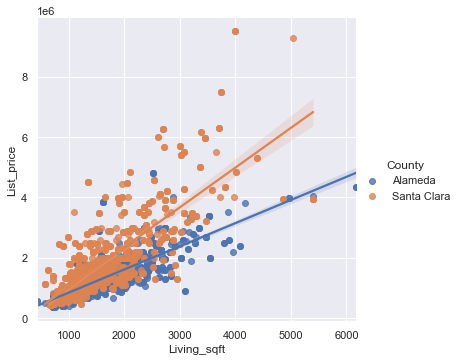

In [43]:
sns.lmplot(x = "Living_sqft", y = 'List_price', data=df1, hue = "County")
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
plt.show()

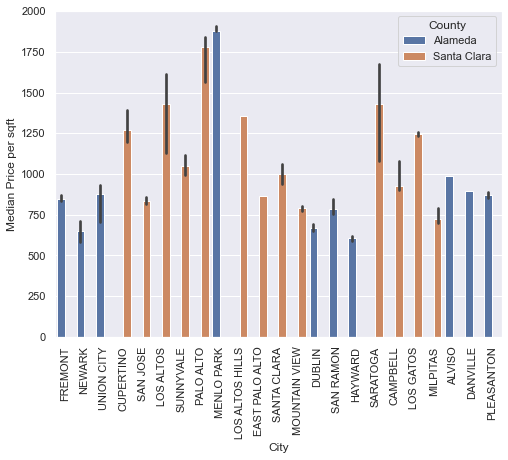

In [45]:
from numpy import median
sns.barplot(x = "City", y = 'Price_Sq_Ft_', data=df1, hue = "County", estimator = median)
sns.set(rc = {'figure.figsize':(8,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median Price per sqft')
plt.xticks(rotation=90)
plt.show()

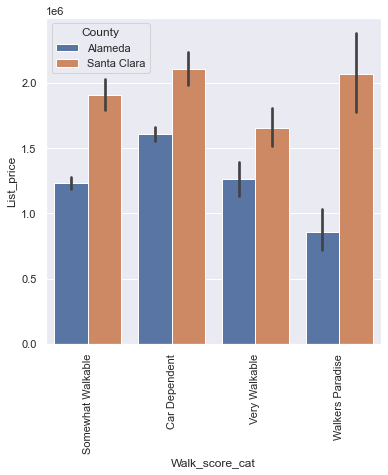

In [47]:
sns.barplot(x = "Walk_score_cat", y = 'List_price', data=df1, hue = "County")
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
sns.set(rc = {'figure.figsize':(6,6)})
plt.xticks(rotation=90)
plt.show()

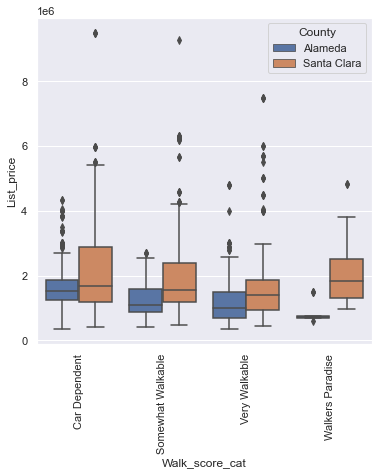

In [489]:
sns.boxplot(x = "Walk_score_cat", y = "List_price" , data = df1, hue = "County")
sns.set(rc = {'figure.figsize':(6,6)})
plt.xticks(rotation=90)
plt.show()

In [48]:
df1.Walk_score_cat.value_counts()

Car Dependent        980
Somewhat Walkable    740
Very Walkable        439
Walkers Paradise      54
Name: Walk_score_cat, dtype: int64

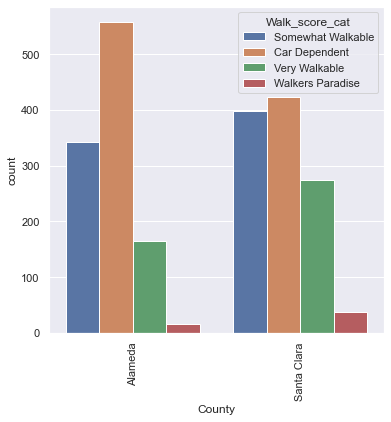

In [49]:
sns.countplot(x ='County', hue = "Walk_score_cat", data = df1)
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
sns.set(rc = {'figure.figsize':(6,6)})
plt.xticks(rotation=90)
plt.show()

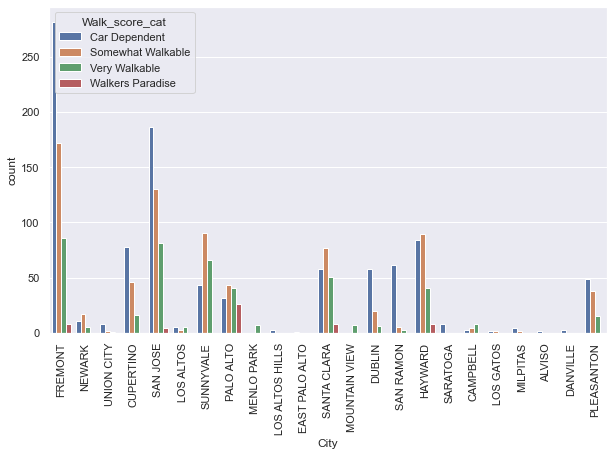

In [91]:
sns.countplot(x ='City', hue = "Walk_score_cat", data = df1)
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
sns.set(rc = {'figure.figsize':(25,6)})
plt.xticks(rotation=90)
plt.show()

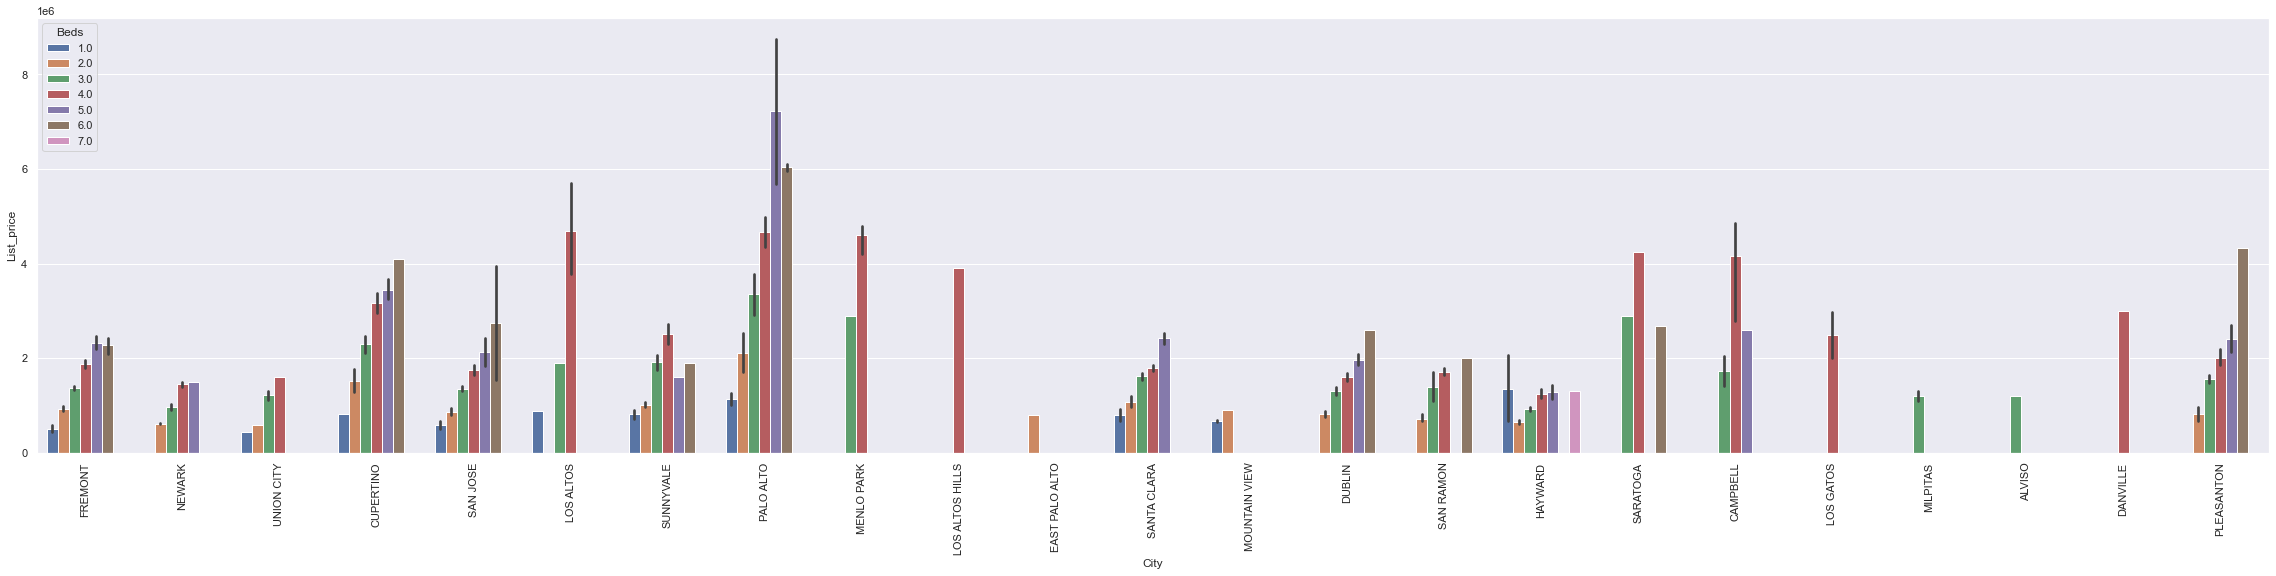

In [53]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "Beds")
sns.set(rc = {'figure.figsize':(40,8)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
plt.xticks(rotation=90)
plt.show()

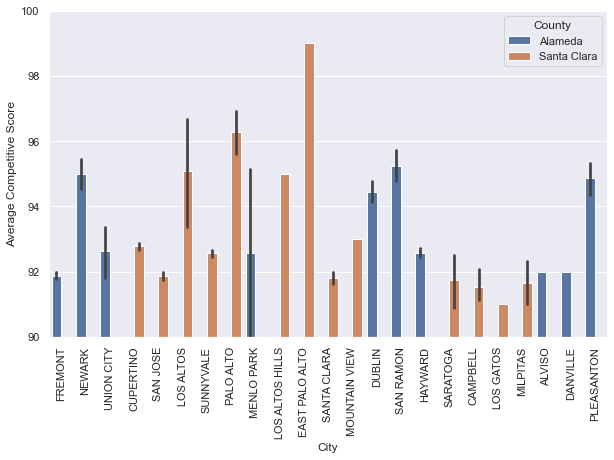

In [56]:
gfg = sns.barplot(x = "City", y = 'Competitive_Score', data=df1, hue = "County")
gfg.set_ylim(90, 100)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Average Competitive Score')
plt.xticks(rotation=90)
plt.show()



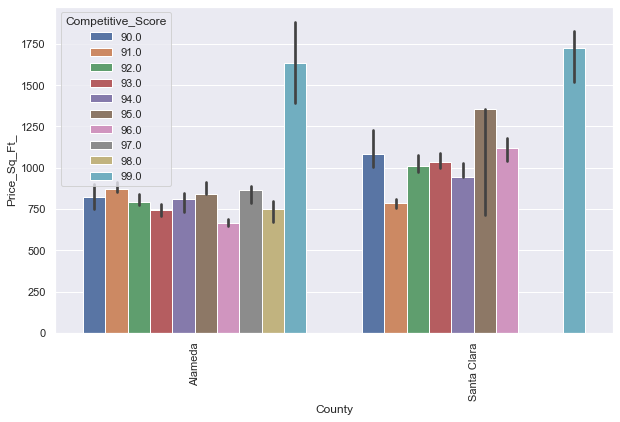

In [57]:
sns.barplot(x = "County", y = 'Price_Sq_Ft_', data=df1, hue = "Competitive_Score", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Average price per sqft')
plt.xticks(rotation=90)
plt.show()

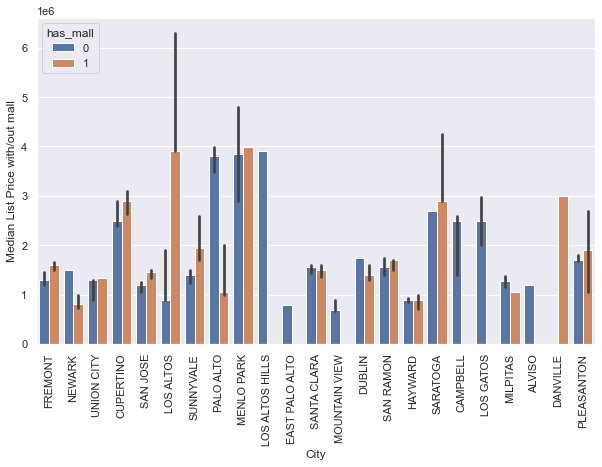

In [58]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "has_mall", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out mall')
plt.xticks(rotation=90)
plt.show()

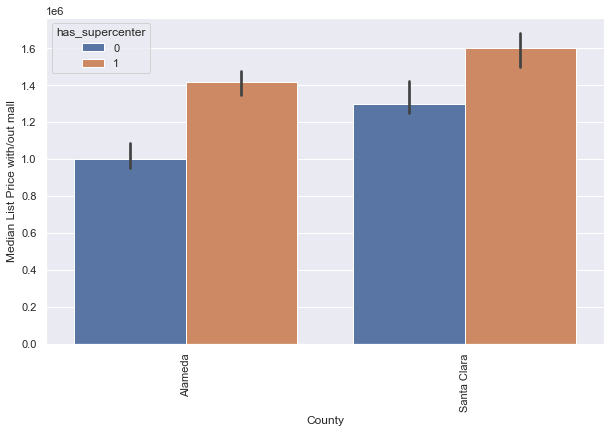

In [59]:
sns.barplot(x = "County", y = 'List_price', data=df1, hue = "has_supercenter", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out mall')
plt.xticks(rotation=90)
plt.show()

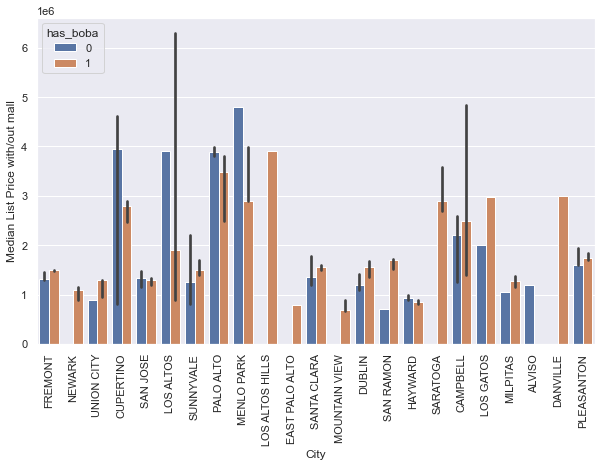

In [60]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "has_boba", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out mall')
plt.xticks(rotation=90)
plt.show()

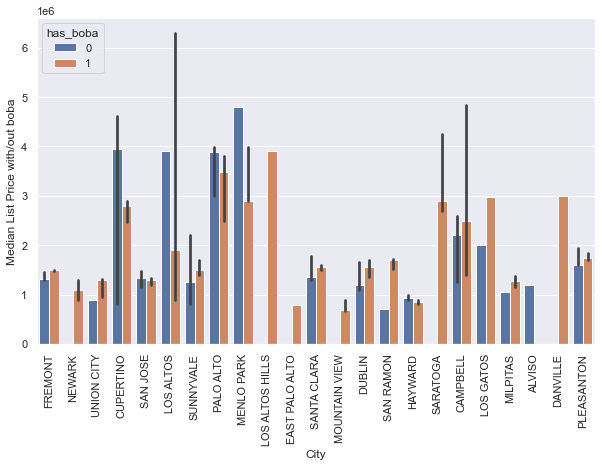

In [61]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "has_boba", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out boba')
plt.xticks(rotation=90)
plt.show()

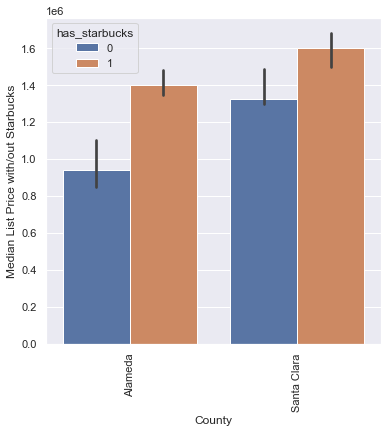

In [66]:
sns.barplot(x = "County", y = 'List_price', data=df1, hue = "has_starbucks", estimator =median)
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out Starbucks')
plt.xticks(rotation=90)
plt.show()

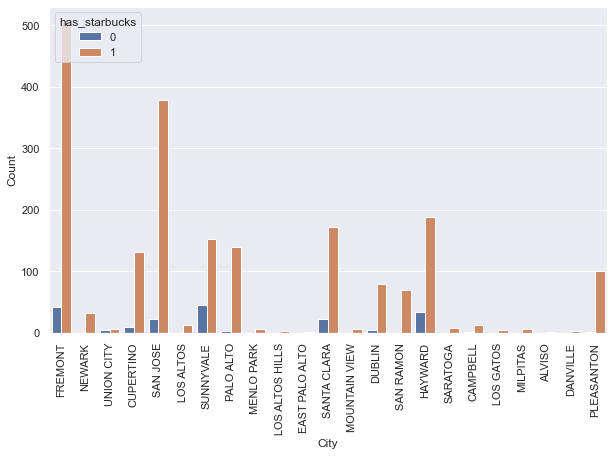

In [68]:
sns.countplot(x = "City", data=df1, hue = "has_starbucks")
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

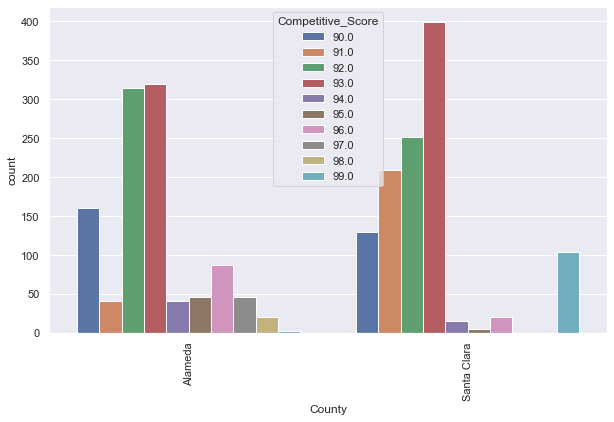

In [69]:
sns.countplot(x = "County", data=df1, hue = "Competitive_Score")
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Average price per sqft')
plt.xticks(rotation=90)
plt.show()

In [440]:
df1.dtypes

List_price                   float64
Address                       object
City                          object
State                         object
Beds                         float64
Baths                        float64
Living_sqft                  float64
Property_Type               category
Year_Built                   float64
Price_Sq_Ft_                 float64
Drought_Score                float64
Neighbourhood_Homes          float64
Emergency                      int64
Schools                       object
Competitive_Score            float64
has_supercenter                int64
has_major_indian_grocery       int64
has_major_entertainment        int64
has_indian_restaurant          int64
has_chinese_restaurant         int64
has_mexican_restaurant         int64
has_boba                       int64
has_starbucks                  int64
property_url                  object
has_mall                       int64
Zipcode                       object
No_of_Schools                float64
A

## One hot Encoding

In [70]:
# The column is 'object'; does not have 
# the 'category' definition.

# Need to change object variable type to 'category'. 
colslist = ['Property_Type', 'County', 'Walk_score_cat']
for i in colslist:
    df1[i] = df1[i].astype('category')
    print(df1[i].cat.categories)
    print(df1[i].dtype)

One_hot_Property_Type = pd.get_dummies(df1['Property_Type'], prefix = 'Property_Type', prefix_sep ='_', 
                            drop_first=False)
One_hot_County = pd.get_dummies(df1['County'],prefix ='County',  prefix_sep='_', 
                            drop_first=False)
One_hot_Walk_score_cat = pd.get_dummies(df1['Walk_score_cat'], prefix = 'Walk_score_cat', prefix_sep='_', 
                            drop_first=False)

# # Display category levels (attributes) and category type.
# print(' ')
# print('Category levels and changed variable type:')
# print(df1.County.cat.categories)  # It can take one of three levels.
# print(df1.County.dtype)  # Type is now 'category'.

Index(['Condo', 'Single', 'Townhouse'], dtype='object')
category
Index(['Alameda', 'Santa Clara'], dtype='object')
category
Index(['Car Dependent', 'Somewhat Walkable', 'Very Walkable',
       'Walkers Paradise'],
      dtype='object')
category


In [71]:
df_new = pd.concat([df1.drop(['Walk_score_cat', 'Property_Type', 'County'],axis = 1), One_hot_Walk_score_cat, One_hot_Property_Type, One_hot_County], axis = 1)

In [72]:
df_new.columns

Index(['List_price', 'Address', 'City', 'State', 'Beds', 'Baths',
       'Living_sqft', 'Year_Built', 'Price_Sq_Ft_', 'Drought_Score',
       'Neighbourhood_Homes', 'Emergency', 'Competitive_Score',
       'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'property_url', 'has_mall', 'Zipcode', 'No_of_Schools',
       'Average_rating', 'Walk_score_cat_Car Dependent',
       'Walk_score_cat_Somewhat Walkable', 'Walk_score_cat_Very Walkable',
       'Walk_score_cat_Walkers Paradise', 'Property_Type_Condo',
       'Property_Type_Single', 'Property_Type_Townhouse', 'County_Alameda',
       'County_Santa Clara'],
      dtype='object')

In [73]:
df_new.to_csv('Analysis_data.csv', index = False)

In [74]:
price_df = pd.read_csv('Analysis_data.csv')

In [75]:
len(price_df.columns)

35

In [76]:
price_df.describe().columns

Index(['List_price', 'Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Car Dependent', 'Walk_score_cat_Somewhat Walkable',
       'Walk_score_cat_Very Walkable', 'Walk_score_cat_Walkers Paradise',
       'Property_Type_Condo', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Alameda', 'County_Santa Clara'],
      dtype='object')

In [77]:
print('Modified column titles with no space and one word for titles:')
price_df.columns = [s.strip().replace(' ', '_') for s in price_df.columns]
price_df.columns

Modified column titles with no space and one word for titles:


Index(['List_price', 'Address', 'City', 'State', 'Beds', 'Baths',
       'Living_sqft', 'Year_Built', 'Price_Sq_Ft_', 'Drought_Score',
       'Neighbourhood_Homes', 'Emergency', 'Competitive_Score',
       'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'property_url', 'has_mall', 'Zipcode', 'No_of_Schools',
       'Average_rating', 'Walk_score_cat_Car_Dependent',
       'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable',
       'Walk_score_cat_Walkers_Paradise', 'Property_Type_Condo',
       'Property_Type_Single', 'Property_Type_Townhouse', 'County_Alameda',
       'County_Santa_Clara'],
      dtype='object')

In [78]:
price_df.describe().columns

Index(['List_price', 'Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Car_Dependent', 'Walk_score_cat_Somewhat_Walkable',
       'Walk_score_cat_Very_Walkable', 'Walk_score_cat_Walkers_Paradise',
       'Property_Type_Condo', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Alameda', 'County_Santa_Clara'],
      dtype='object')

## Multiple Linear Regression model - without normalization because weights or the coeffecients are going take care of the domainance of variables with higher values over the variables with lower values 

## 5-Fold Cross validation

In [80]:
predictors = ['Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Car_Dependent', 'Walk_score_cat_Somewhat_Walkable',
       'Walk_score_cat_Very_Walkable', 'Walk_score_cat_Walkers_Paradise',
       'Property_Type_Condo', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Alameda', 'County_Santa_Clara']
outcome = 'List_price'



# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
Regression = LinearRegression()

# Use cross_val_score() function to identify performance 
# accuracy for 5 folds (cv=5) of cross-validation partitioning.
scores = cross_val_score(Regression, train_X, train_y, cv=5)

# Display performance accuracy scores for each fold partition.
# Use three decimals (.3f) for each accuracy score using the 
# acc (accumulator) parameter. 
print('Performance Accuracy of 5-Fold Cross-Validation')
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])

# Indetify and display two standard deviation confidence interval for 
# population mean scores.
print()
print('Two Standard Deviation (95%) Confidence Interval for Mean Accuracy')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')

Performance Accuracy of 5-Fold Cross-Validation
Accuracy scores of each fold:  ['0.896', '0.925', '0.915', '0.893', '0.908']

Two Standard Deviation (95%) Confidence Interval for Mean Accuracy
Accuracy: 0.908 (+/- 0.024)


## ## Multiple Linear Regression model - with all variables

In [84]:
# Identify predictors and outcome of the regression model. Not including irrelevant columns
#'Address', 'City', 'State', 'zipcode' in regression 
#because these variables do not have any effect on the model
predictors = ['Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Car_Dependent', 'Walk_score_cat_Somewhat_Walkable',
       'Walk_score_cat_Very_Walkable', 'Walk_score_cat_Walkers_Paradise',
       'Property_Type_Condo', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Alameda', 'County_Santa_Clara']
outcome = 'List_price'



# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
price_lm = LinearRegression()
price_lm.fit(train_X, train_y)

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for Prices Training Set')
print()
print('Intercept: ', np.round(price_lm.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(price_lm.coef_, 2)}))

Regression Model for Prices Training Set

Intercept:  -1687649.51
                           Predictor  Coefficient
0                               Beds    -18169.94
1                              Baths     28927.75
2                        Living_sqft      1076.77
3                         Year_Built        25.33
4                       Price_Sq_Ft_      1695.99
5                      Drought_Score      2027.36
6                Neighbourhood_Homes      -266.29
7                          Emergency      5878.82
8                  Competitive_Score     -4621.64
9                    has_supercenter    131139.09
10          has_major_indian_grocery    -10694.34
11           has_major_entertainment     15421.23
12             has_indian_restaurant   -119103.74
13            has_chinese_restaurant   -118686.02
14            has_mexican_restaurant     19170.79
15                          has_boba     42047.50
16                     has_starbucks     40906.45
17                          has_ma

In [85]:
# Create a data frame that inlcudes predictors and
# outcome (Price) for training set.
train_df_sm = train_X.join(train_y)

# Display columns in train_df data frame.
train_df_sm.columns

# Create predictors for the model.
predictors_sm = train_X.columns

# Develop regression model formula, where
# Price is outcome and 11 predictors. 
formula = 'train_y ~ ' + ' + '.join(predictors_sm)

# Create multiple regression model using sm.ols()
# function from statsmodels library.
car_lm_sm = sm.ols(formula=formula, data=train_df_sm).fit()

# Display regression summary.
print(car_lm_sm.summary()) 

# The regression coefficients are the same as for the 
# regression model using LinearRegression() function 
# from scikit-learn library.

                            OLS Regression Results                            
Dep. Variable:                train_y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     514.4
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        10:57:22   Log-Likelihood:                -18717.
No. Observations:                1327   AIC:                         3.749e+04
Df Residuals:                    1300   BIC:                         3.763e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Multiple linear regression with significant variables from previous model

In [86]:
predictors = ['Living_sqft','Price_Sq_Ft_','Emergency','has_supercenter','has_indian_restaurant','has_chinese_restaurant','has_mall','Average_rating','Walk_score_cat_Walkers_Paradise','Property_Type_Single']
outcome = 'List_price'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
price_lm = LinearRegression()
price_lm.fit(train_X, train_y)

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for Prices Training Set')
print()
print('Intercept: ', np.round(price_lm.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(price_lm.coef_, 2)}))

# Apply sm.ols() function from statsmodels library
# to run a linear regression of Price on the 
# 11 predictors (including 2 dummy variables)
# in the training set.

# Create a data frame that inlcudes 11 predictors and
# outcome (Price) for training set.
train_df_sm = train_X.join(train_y)

# Display columns in train_df data frame.
train_df_sm.columns

# Create predictors for the model.
predictors_sm = train_X.columns

# Develop regression model formula, where
# Price is outcome and 11 predictors. 
formula = 'train_y ~ ' + ' + '.join(predictors_sm)

# Create multiple regression model using sm.ols()
# function from statsmodels library.
car_lm_sm = sm.ols(formula=formula, data=train_df_sm).fit()

# Display regression summary.
print(car_lm_sm.summary()) 

# The regression coefficients are the same as for the 
# regression model using LinearRegression() function 
# from scikit-learn library.

Regression Model for Prices Training Set

Intercept:  -1786830.59
                         Predictor  Coefficient
0                      Living_sqft      1080.39
1                     Price_Sq_Ft_      1724.93
2                        Emergency      6089.15
3                  has_supercenter    141773.79
4            has_indian_restaurant   -116544.85
5           has_chinese_restaurant    -98594.54
6                         has_mall    -99363.67
7                   Average_rating     16199.83
8  Walk_score_cat_Walkers_Paradise    -88370.75
9             Property_Type_Single   -161260.07
                            OLS Regression Results                            
Dep. Variable:                train_y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1329.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:      

In [87]:
# Living_sqft,Price_Sq_Ft_,Emergency,has_supercenter,has_indian_restaurant,has_chinese_restaurant,has_mall,Average_rating,Walk_score_cat_Walkers_Paradise,Property_Type_Single
# Use predict() to score (make) predictions for validation set.
price_lm_pred = price_lm.predict(valid_X)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
print('Actual, Prediction, and Residual Prices for Validation Set\n\n')
result = round(pd.DataFrame({'Actual': valid_y,'Predicted': price_lm_pred, 
                       'Residual': valid_y - price_lm_pred}), 2)
print(result.head(15))

Actual, Prediction, and Residual Prices for Validation Set


         Actual   Predicted    Residual
1407  1650000.0  1634638.54    15361.46
1585  1348800.0  1244940.36   103859.64
1032  1750000.0  1846125.89   -96125.89
415   4050000.0  3704350.79   345649.21
201    349000.0  -129841.09   478841.09
194    799000.0   793500.40     5499.60
1268  2388000.0  2410353.94   -22353.94
549   1298000.0  1173363.08   124636.92
126   1302195.0  1410170.35  -107975.35
363   2437000.0  4090717.24 -1653717.24
778   2499950.0  3361094.43  -861144.43
1751  1998000.0  2453133.50  -455133.50
702    948000.0   907224.41    40775.59
1362  1998800.0  2326470.38  -327670.38
1224   999888.0  1064464.23   -64576.23


In [88]:
# Use predict() function to make predictions for
# training set.
pred_y = price_lm.predict(train_X)

# Create prediction performance measures for training set.
r2 = round(r2_score(train_y, pred_y),3)
adj_r2 = round(adjusted_r2_score(train_y, pred_y, price_lm),3)


# Display prediction performance measures for training set.
print('Prediction Performance Measures for Training Set')
print('r2 : ', r2)
print('Adjusted r2 : ', adj_r2)

print() 

# Create prediction performance measures for validation set.
r2 = round(r2_score(valid_y, price_lm_pred),3)
adj_r2 = round(adjusted_r2_score(valid_y, price_lm_pred, price_lm),3)


# Display prediction performance measures for validation set.
print('Prediction Performance Measures for Validation Set')
print('r2 : ', r2)
print('adjusted r2 : ', adj_r2)


Prediction Performance Measures for Training Set
r2 :  0.91
Adjusted r2 :  0.909

Prediction Performance Measures for Validation Set
r2 :  0.927
adjusted r2 :  0.926


In [557]:
# Display common accuracy measures for training set.
print('Accuracy Measures for Training Set - All Variables')
regressionSummary(train_y, pred_y)
print()

# Display common accuracy measures for validation set.
print('Accuracy Measures for Validation Set - All Variables')
regressionSummary(valid_y, price_lm_pred)

Accuracy Measures for Training Set - All Variables

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 323124.3620
            Mean Absolute Error (MAE) : 193884.6340
          Mean Percentage Error (MPE) : 2.1049
Mean Absolute Percentage Error (MAPE) : 13.9264

Accuracy Measures for Validation Set - All Variables

Regression statistics

                      Mean Error (ME) : -10864.1563
       Root Mean Squared Error (RMSE) : 265818.9386
            Mean Absolute Error (MAE) : 177673.3060
          Mean Percentage Error (MPE) : 1.8360
Mean Absolute Percentage Error (MAPE) : 12.9010
